In [7]:
# Wrap cells

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sklearn.feature_extraction
from sklearn.svm import SVC

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip

In [ ]:
%cd fastText-0.9.2

!pip install .

In [5]:
import fasttext as ft

In [56]:
# Import the dataset, prepared in "1-Data-Preparation.ipynb" and the datasets in FastText format
dataset = pd.read_csv("/content/fastText-0.9.2/MT-GINCO-split-objectivity-dataset.csv")
dataset.head()

,text,label,split
0,"For the first time since 2008 <p/> Dallas, 12....",subjective,train
1,"17 replies to "" Even in the municipality of Ra...",subjective,train
2,Esimit Europa <p/> Vasili's main sponsor is Es...,subjective,train
3,Beekeepers' successes <p/> The 37th National M...,objective,train
4,Kundalini Yoga <p/> GUIDE <p/> Kundalini Yoga ...,subjective,train


In [57]:
# Change the labels into FastText-appropriate format
ft_labels = {"objective":"__label__objective", "subjective":"__label__subjective"}

dataset["label"].replace(ft_labels, inplace=True)
dataset.head(1)

,text,label,split
0,"For the first time since 2008 <p/> Dallas, 12....",__label__subjective,train


In [58]:
labels = list(dataset.label.unique())
labels

['__label__subjective', '__label__objective']

In [59]:
# Split the dataset into train and test split: X are texts, Y are labels
train_df = dataset[dataset["split"] == "train"]
X_train = list(train_df.text)
Y_train = list(train_df.label)

test_df = dataset[dataset["split"] == "test"]
X_test = list(test_df.text)
Y_test = list(test_df.label)

print(len(X_test), len(Y_test))

127 127


In [61]:
# Then create CSV files which FastText can read

train_file_content=""

for labels, text in train_df.loc[:, ["label", "text"]].values:
    train_file_content += f"""{labels} {text}\n"""

with open("/content/MT-GINCORE-objectivness-fasttext.train","w") as train_file:
    train_file.write(train_file_content)

test_file_content=""

for labels, text in test_df.loc[:, ["label", "text"]].values:
    test_file_content += f"""{labels} {text}\n"""

with open("/content/MT-GINCORE-objectivness-fasttext.test","w") as test_file:
    test_file.write(test_file_content)

In [62]:
train_file = "/content/MT-GINCORE-objectivness-fasttext.train"
test_file = "/content/MT-GINCORE-objectivness-fasttext.test"

In [64]:
# Create a list of labels in a FastText-appropriate format:
LABELS = train_df.label.unique().tolist()
LABELS

['__label__subjective', '__label__objective']

In [65]:
# train the model

model = ft.train_supervised(input=train_file,
                                epoch = 350,
                                lr = 0.7,
                                wordNgrams=1,
                                verbose = 2)

In [66]:
# Evaluate the model on test data
y_pred = model.predict(list(test_df.text))
y_pred = np.array(y_pred[0])[:, 0]
y_pred

array(['__label__subjective', '__label__subjective',
       '__label__subjective', '__label__objective', '__label__subjective',
       '__label__subjective', '__label__subjective', '__label__objective',
       '__label__subjective', '__label__subjective',
       '__label__subjective', '__label__subjective',
       '__label__subjective', '__label__objective', '__label__objective',
       '__label__subjective', '__label__subjective', '__label__objective',
       '__label__subjective', '__label__subjective',
       '__label__subjective', '__label__subjective', '__label__objective',
       '__label__subjective', '__label__objective', '__label__subjective',
       '__label__subjective', '__label__subjective',
       '__label__subjective', '__label__subjective', '__label__objective',
       '__label__subjective', '__label__objective', '__label__subjective',
       '__label__objective', '__label__subjective', '__label__subjective',
       '__label__subjective', '__label__subjective', '__label

In [67]:
Y_test

['__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__objective',
 '__label__subjective',
 '__label__subjective',
 '__label__objective',
 '__label__objective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__objective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__objective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__objective',
 '__label__objective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__objective',
 '__label__subjective',
 '__label__subjective',
 '__label__objective',
 '__label__subjective',
 '__label__objective',
 '__label__objective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__subjective',
 '__label__objective',
 '__label__subjective',
 '__label__objective',
 '__l

([<matplotlib.axis.XTick at 0x7f90f8068f90>,
 [Text(0, 0, '__label__subjective'), Text(0, 0, '__label__objective')])

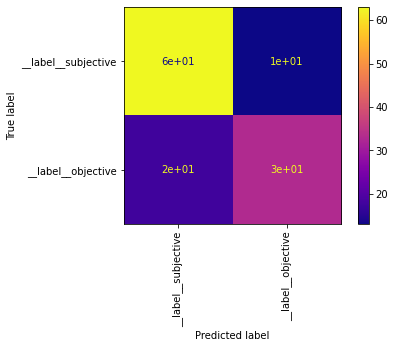

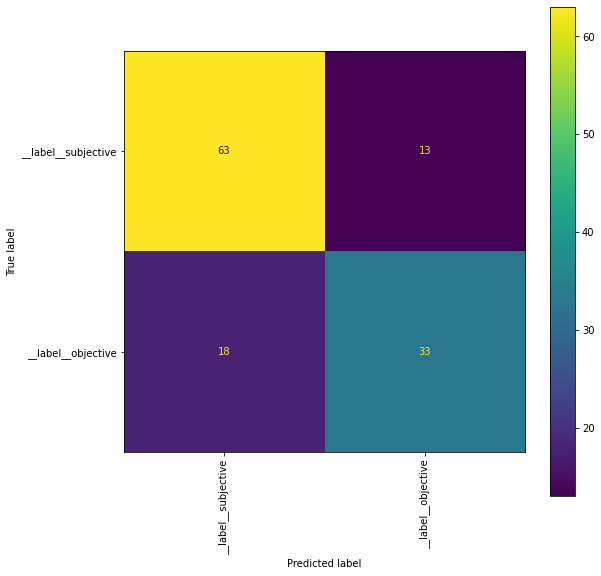

In [68]:
# Plot the confusion matrix for the desired model. You can normalise the values with the attribute "normalize":
# "true" - normalize across rows, "all" = normalize by total no. of samples,
# "pred" - normalize across columns
dp = ConfusionMatrixDisplay.from_predictions(list(Y_test), list(y_pred), labels = LABELS, xticks_rotation=90, cmap='plasma', colorbar=True, values_format=".1g")

# To make the plot bigger:
fig, ax = plt.subplots(figsize=(9,9))
dp.plot(ax=ax)
plt.xticks(np.arange(len(LABELS)), LABELS, rotation=90)

In [69]:
# Save the results
results = {}


y_pred_list = list(y_pred)

model_name="FastText"
micro_f1_array = round(f1_score(Y_test, y_pred, labels=labels, average ="micro"),3)
macro_f1_array = round(f1_score(Y_test, y_pred, labels=labels, average ="macro"),3)
accuracy_array = round(metrics.accuracy_score(Y_test, y_pred),3)

results = {"model":model_name, "microF1": micro_f1_array, "macroF1":macro_f1_array, "accuracy":accuracy_array, "y_pred":y_pred_list}

In [70]:
print(results)

{'model': 'FastText', 'microF1': 0.756, 'macroF1': 0.741, 'accuracy': 0.756, 'y_pred': ['__label__subjective', '__label__subjective', '__label__subjective', '__label__objective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__objective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__objective', '__label__objective', '__label__subjective', '__label__subjective', '__label__objective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__objective', '__label__subjective', '__label__objective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__objective', '__label__subjective', '__label__objective', '__label__subjective', '__label__objective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__subjective', '__label__objective', '__

In [71]:
# Save results as JSON file
import json

with open("fastText_results.json","w") as file:
  json.dump(results, file)